<a href="https://colab.research.google.com/github/PLEX-GR00T/3D-Object-Detection/blob/main/PyTorch_object_detection_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fiftyone
!pip install torch torchvision

     |████████████████████████████████| 2.2MB 16.4MB/s 
     |████████████████████████████████| 112kB 56.3MB/s 
     |████████████████████████████████| 512kB 46.1MB/s 
     |████████████████████████████████| 225kB 42.6MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
     |████████████████████████████████| 563kB 32.8MB/s 
     |████████████████████████████████| 29.3MB 106kB/s 
     |████████████████████████████████| 36.7MB 71kB/s 
     |████████████████████████████████| 194kB 59.6MB/s 
     |████████████████████████████████| 163kB 48.5MB/s 
     |████████████████████████████████| 81kB 12.1MB/s 
     |████████████████████████████████| 71kB 10.5MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
     |████████████████████████████████| 61kB 9.4MB/s 


In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../


Cloning into 'vision'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 18391 (delta 78), reused 42 (delta 7), pack-reused 18265
Receiving objects: 100% (18391/18391), 17.21 MiB | 24.65 MiB/s, done.
Resolving deltas: 100% (13365/13365), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


## Loading your data


In [ ]:
import torch

torch.manual_seed(1)

In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz

In [ ]:
fo_dataset = foz.load_zoo_dataset("coco-2017", "validation")

 100% |██████|    6.1Gb/6.1Gb [10.6s elapsed, 0s remaining, 502.3Mb/s]      
Extracting images to '/root/fiftyone/coco-2017/tmp-download/val2017'
 100% |██████|    1.9Gb/1.9Gb [4.1s elapsed, 0s remaining, 502.3Mb/s]      
Extracting annotations to '/root/fiftyone/coco-2017/tmp-download/annotations/instances_val2017.json'
loading annotations into memory...
Done (t=0.54s)
creating index...
index created!
 100% |███████████████| 5000/5000 [1.7m elapsed, 0s remaining, 52.2 samples/s]      
Dataset info written to '/root/fiftyone/coco-2017/info.json'
Loading 'coco-2017' split 'validation'
 100% |███████████████| 5000/5000 [37.3s elapsed, 0s remaining, 130.1 samples/s]      
Dataset 'coco-2017-validation' created


In [ ]:
fo_dataset.compute_metadata()

 100% |███████████████| 5000/5000 [55.2s elapsed, 0s remaining, 142.6 samples/s]      


## Dataset and training setup


In [ ]:
import torch
import fiftyone.utils.coco as fouc
from PIL import Image


class FiftyOneTorchDataset(torch.utils.data.Dataset):
    """A class to construct a PyTorch dataset from a FiftyOne dataset.
    
    Args:
        fiftyone_dataset: a FiftyOne dataset or view that will be used for training or testing
        transforms (None): a list of PyTorch transforms to apply to images and targets when loading
        gt_field ("ground_truth"): the name of the field in fiftyone_dataset that contains the 
            desired labels to load
        classes (None): a list of class strings that are used to define the mapping between
            class names and indices. If None, it will use all classes present in the given fiftyone_dataset.
    """

    def __init__(
        self,
        fiftyone_dataset,
        transforms=None,
        gt_field="ground_truth",
        classes=None,
    ):
        self.samples = fiftyone_dataset
        self.transforms = transforms
        self.gt_field = gt_field

        self.img_paths = self.samples.values("filepath")

        self.classes = classes
        if not self.classes:
            # Get list of distinct labels that exist in the view
            self.classes = self.samples.distinct(
                "%s.detections.label" % gt_field
            )

        if self.classes[0] != "background":
            self.classes = ["background"] + self.classes

        self.labels_map_rev = {c: i for i, c in enumerate(self.classes)}

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        sample = self.samples[img_path]
        metadata = sample.metadata
        img = Image.open(img_path).convert("RGB")

        boxes = []
        labels = []
        area = []
        iscrowd = []
        detections = sample[self.gt_field].detections
        for det in detections:
            category_id = self.labels_map_rev[det.label]
            coco_obj = fouc.COCOObject.from_detection(
                det, metadata, category_id=category_id,
            )
            x, y, w, h = coco_obj.bbox
            boxes.append([x, y, x + w, y + h])
            labels.append(coco_obj.category_id)
            area.append(coco_obj.area)
            iscrowd.append(coco_obj.iscrowd)

        target = {}
        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
        target["image_id"] = torch.as_tensor([idx])
        target["area"] = torch.as_tensor(area, dtype=torch.float32)
        target["iscrowd"] = torch.as_tensor(iscrowd, dtype=torch.int64)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.img_paths)

    def get_classes(self):
        return self.classes

The following code loads Faster-RCNN with a ResNet50 backbone from Torchvision and modifies the classifier for the number of classes we are training on:

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes):
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
# Import functions from the torchvision references we cloned
from engine import train_one_epoch, evaluate
import utils

def do_training(model, torch_dataset, torch_dataset_test, num_epochs=4):
    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        torch_dataset, batch_size=2, shuffle=True, num_workers=2,
        collate_fn=utils.collate_fn)
    
    data_loader_test = torch.utils.data.DataLoader(
        torch_dataset_test, batch_size=1, shuffle=False, num_workers=2,
        collate_fn=utils.collate_fn)

    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print("Using device %s" % device)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                    step_size=3,
                                                    gamma=0.1)

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)

        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

Now, we want to train a model that is used primarily for road vehicle detection. We can easily create training and testing views (and corresponding PyTorch datasets) that only contain the classes car, truck, and bus:

In [ ]:
from fiftyone import ViewField as F

vehicles_list = ["car", "truck", "bus"]
vehicles_view = fo_dataset.filter_labels("ground_truth",
        F("label").is_in(vehicles_list))

print(len(vehicles_view))

707



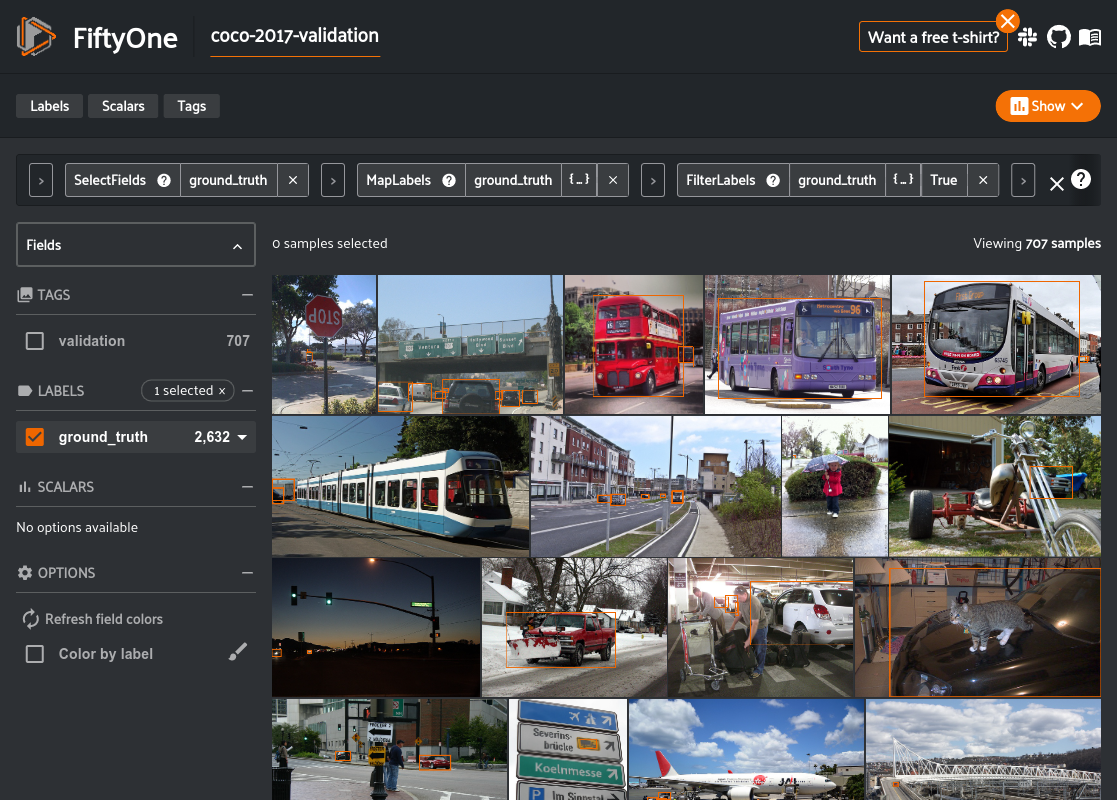

In [ ]:
session.view = vehicles_view

In [ ]:
# From the torchvision references we cloned
import transforms as T

train_transforms = T.Compose([T.ToTensor(), T.RandomHorizontalFlip(0.5)])
test_transforms = T.Compose([T.ToTensor()])

In [ ]:
# split the dataset in train and test set
train_view = vehicles_view.take(500, seed=51)
test_view = vehicles_view.exclude([s.id for s in train_view])

In [ ]:
# use our dataset and defined transformations
torch_dataset = FiftyOneTorchDataset(train_view, train_transforms,
        classes=vehicles_list)
torch_dataset_test = FiftyOneTorchDataset(test_view, test_transforms, 
        classes=vehicles_list)

## Training and Evaluation

In this section, we use the functions and datasets we defined above to initialize, train, and evaluate a model continuing with the vehicle example. 

In [ ]:
model = get_model(len(vehicles_list)+1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [ ]:
do_training(model, torch_dataset, torch_dataset_test, num_epochs=4)

Using device cuda


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Epoch: [0]  [  0/250]  eta: 0:05:48  lr: 0.000025  loss: 2.0424 (2.0424)  loss_classifier: 1.3071 (1.3071)  loss_box_reg: 0.6820 (0.6820)  loss_objectness: 0.0361 (0.0361)  loss_rpn_box_reg: 0.0172 (0.0172)  time: 1.3925  data: 0.2820  max mem: 3094
Epoch: [0]  [ 10/250]  eta: 0:02:39  lr: 0.000226  loss: 1.8390 (1.7483)  loss_classifier: 1.2389 (1.1791)  loss_box_reg: 0.5072 (0.4188)  loss_objectness: 0.0438 (0.0689)  loss_rpn_box_reg: 0.0219 (0.0814)  time: 0.6632  data: 0.0323  max mem: 3506
Epoch: [0]  [ 20/250]  eta: 0:02:21  lr: 0.000426  loss: 1.2446 (1.3204)  loss_classifier: 0.7553 (0.8323)  loss_box_reg: 0.2559 (0.3675)  loss_objectness: 0.0349 (0.0595)  loss_rpn_box_reg: 0.0190 (0.0612)  time: 0.5744  data: 0.0070  max mem: 3506
Epoch: [0]  [ 30/250]  eta: 0:02:12  lr: 0.000627  loss: 0.9709 (1.1985)  loss_classifier: 0.5002 (0.7143)  loss_box_reg: 0.3701 (0.3838)  loss_objectness: 0.0290 (0.0493)  loss_rpn_box_reg: 0.0190 (0.0511)  time: 0.5688  data: 0.0068  max mem: 3506


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Test:  [  0/207]  eta: 0:01:08  model_time: 0.1717 (0.1717)  evaluator_time: 0.0182 (0.0182)  time: 0.3311  data: 0.1394  max mem: 4211
Test:  [100/207]  eta: 0:00:13  model_time: 0.1220 (0.1176)  evaluator_time: 0.0048 (0.0063)  time: 0.1298  data: 0.0034  max mem: 4211
Test:  [200/207]  eta: 0:00:00  model_time: 0.1123 (0.1173)  evaluator_time: 0.0035 (0.0061)  time: 0.1228  data: 0.0036  max mem: 4211
Test:  [206/207]  eta: 0:00:00  model_time: 0.1130 (0.1173)  evaluator_time: 0.0061 (0.0062)  time: 0.1256  data: 0.0036  max mem: 4211
Test: Total time: 0:00:26 (0.1292 s / it)
Averaged stats: model_time: 0.1130 (0.1173)  evaluator_time: 0.0061 (0.0062)
Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.062
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.147
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.046
 Average Precision  (AP) @[ I

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Epoch: [1]  [  0/250]  eta: 0:03:36  lr: 0.005000  loss: 0.7783 (0.7783)  loss_classifier: 0.2188 (0.2188)  loss_box_reg: 0.3122 (0.3122)  loss_objectness: 0.2095 (0.2095)  loss_rpn_box_reg: 0.0379 (0.0379)  time: 0.8654  data: 0.3291  max mem: 4211
Epoch: [1]  [ 10/250]  eta: 0:02:30  lr: 0.005000  loss: 0.4352 (0.4338)  loss_classifier: 0.1951 (0.1744)  loss_box_reg: 0.1519 (0.1611)  loss_objectness: 0.0443 (0.0770)  loss_rpn_box_reg: 0.0099 (0.0213)  time: 0.6275  data: 0.0362  max mem: 4211
Epoch: [1]  [ 20/250]  eta: 0:02:21  lr: 0.005000  loss: 0.4352 (0.4672)  loss_classifier: 0.1951 (0.1943)  loss_box_reg: 0.1854 (0.1962)  loss_objectness: 0.0252 (0.0554)  loss_rpn_box_reg: 0.0140 (0.0214)  time: 0.6041  data: 0.0066  max mem: 4211
Epoch: [1]  [ 30/250]  eta: 0:02:17  lr: 0.005000  loss: 0.4343 (0.4460)  loss_classifier: 0.1785 (0.1889)  loss_box_reg: 0.1912 (0.1886)  loss_objectness: 0.0244 (0.0472)  loss_rpn_box_reg: 0.0160 (0.0213)  time: 0.6212  data: 0.0065  max mem: 4211


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Test:  [  0/207]  eta: 0:01:08  model_time: 0.1723 (0.1723)  evaluator_time: 0.0091 (0.0091)  time: 0.3287  data: 0.1455  max mem: 4400
Test:  [100/207]  eta: 0:00:13  model_time: 0.1208 (0.1177)  evaluator_time: 0.0029 (0.0056)  time: 0.1285  data: 0.0034  max mem: 4400
Test:  [200/207]  eta: 0:00:00  model_time: 0.1131 (0.1174)  evaluator_time: 0.0025 (0.0050)  time: 0.1211  data: 0.0033  max mem: 4400
Test:  [206/207]  eta: 0:00:00  model_time: 0.1138 (0.1174)  evaluator_time: 0.0038 (0.0052)  time: 0.1240  data: 0.0033  max mem: 4400
Test: Total time: 0:00:26 (0.1283 s / it)
Averaged stats: model_time: 0.1138 (0.1174)  evaluator_time: 0.0038 (0.0052)
Accumulating evaluation results...
DONE (t=0.13s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.281
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.497
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ I

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Epoch: [2]  [  0/250]  eta: 0:03:35  lr: 0.005000  loss: 0.2030 (0.2030)  loss_classifier: 0.0742 (0.0742)  loss_box_reg: 0.0981 (0.0981)  loss_objectness: 0.0236 (0.0236)  loss_rpn_box_reg: 0.0070 (0.0070)  time: 0.8602  data: 0.2654  max mem: 4400
Epoch: [2]  [ 10/250]  eta: 0:02:32  lr: 0.005000  loss: 0.2678 (0.3346)  loss_classifier: 0.1189 (0.1501)  loss_box_reg: 0.1305 (0.1487)  loss_objectness: 0.0176 (0.0219)  loss_rpn_box_reg: 0.0094 (0.0138)  time: 0.6360  data: 0.0300  max mem: 4400
Epoch: [2]  [ 20/250]  eta: 0:02:23  lr: 0.005000  loss: 0.2678 (0.3265)  loss_classifier: 0.1222 (0.1480)  loss_box_reg: 0.1305 (0.1383)  loss_objectness: 0.0154 (0.0217)  loss_rpn_box_reg: 0.0147 (0.0186)  time: 0.6119  data: 0.0065  max mem: 4400
Epoch: [2]  [ 30/250]  eta: 0:02:18  lr: 0.005000  loss: 0.3089 (0.3398)  loss_classifier: 0.1295 (0.1498)  loss_box_reg: 0.1501 (0.1533)  loss_objectness: 0.0154 (0.0197)  loss_rpn_box_reg: 0.0124 (0.0170)  time: 0.6232  data: 0.0066  max mem: 4400


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Test:  [  0/207]  eta: 0:01:05  model_time: 0.1593 (0.1593)  evaluator_time: 0.0059 (0.0059)  time: 0.3145  data: 0.1474  max mem: 4401
Test:  [100/207]  eta: 0:00:13  model_time: 0.1216 (0.1176)  evaluator_time: 0.0018 (0.0031)  time: 0.1269  data: 0.0034  max mem: 4401
Test:  [200/207]  eta: 0:00:00  model_time: 0.1130 (0.1175)  evaluator_time: 0.0017 (0.0030)  time: 0.1205  data: 0.0033  max mem: 4401
Test:  [206/207]  eta: 0:00:00  model_time: 0.1130 (0.1174)  evaluator_time: 0.0024 (0.0032)  time: 0.1228  data: 0.0034  max mem: 4401
Test: Total time: 0:00:26 (0.1262 s / it)
Averaged stats: model_time: 0.1130 (0.1174)  evaluator_time: 0.0024 (0.0032)
Accumulating evaluation results...
DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.341
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.547
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.363
 Average Precision  (AP) @[ I

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Epoch: [3]  [  0/250]  eta: 0:03:52  lr: 0.000500  loss: 0.3354 (0.3354)  loss_classifier: 0.1450 (0.1450)  loss_box_reg: 0.1744 (0.1744)  loss_objectness: 0.0091 (0.0091)  loss_rpn_box_reg: 0.0069 (0.0069)  time: 0.9287  data: 0.2996  max mem: 4401
Epoch: [3]  [ 10/250]  eta: 0:02:30  lr: 0.000500  loss: 0.3590 (0.3596)  loss_classifier: 0.1284 (0.1324)  loss_box_reg: 0.1657 (0.1712)  loss_objectness: 0.0196 (0.0204)  loss_rpn_box_reg: 0.0134 (0.0354)  time: 0.6271  data: 0.0325  max mem: 4401
Epoch: [3]  [ 20/250]  eta: 0:02:22  lr: 0.000500  loss: 0.3198 (0.3061)  loss_classifier: 0.1136 (0.1162)  loss_box_reg: 0.1374 (0.1451)  loss_objectness: 0.0121 (0.0153)  loss_rpn_box_reg: 0.0134 (0.0295)  time: 0.6062  data: 0.0064  max mem: 4401
Epoch: [3]  [ 30/250]  eta: 0:02:20  lr: 0.000500  loss: 0.3198 (0.3471)  loss_classifier: 0.1263 (0.1277)  loss_box_reg: 0.1078 (0.1740)  loss_objectness: 0.0081 (0.0147)  loss_rpn_box_reg: 0.0154 (0.0307)  time: 0.6434  data: 0.0067  max mem: 4401


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Test:  [  0/207]  eta: 0:01:08  model_time: 0.1713 (0.1713)  evaluator_time: 0.0073 (0.0073)  time: 0.3321  data: 0.1515  max mem: 4401
Test:  [100/207]  eta: 0:00:13  model_time: 0.1211 (0.1176)  evaluator_time: 0.0018 (0.0031)  time: 0.1284  data: 0.0035  max mem: 4401
Test:  [200/207]  eta: 0:00:00  model_time: 0.1128 (0.1175)  evaluator_time: 0.0016 (0.0030)  time: 0.1211  data: 0.0037  max mem: 4401
Test:  [206/207]  eta: 0:00:00  model_time: 0.1129 (0.1174)  evaluator_time: 0.0026 (0.0032)  time: 0.1239  data: 0.0037  max mem: 4401
Test: Total time: 0:00:26 (0.1267 s / it)
Averaged stats: model_time: 0.1129 (0.1174)  evaluator_time: 0.0026 (0.0032)
Accumulating evaluation results...
DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.359
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.578
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.378
 Average Precision  (AP) @[ I

In [ ]:
import fiftyone as fo

def convert_torch_predictions(preds, det_id, s_id, w, h, classes):
    # Convert the outputs of the torch model into a FiftyOne Detections object
    dets = []
    for bbox, label, score in zip(
        preds["boxes"].cpu().detach().numpy(), 
        preds["labels"].cpu().detach().numpy(), 
        preds["scores"].cpu().detach().numpy()
    ):
        # Parse prediction into FiftyOne Detection object
        x0,y0,x1,y1 = bbox
        coco_obj = fouc.COCOObject(det_id, s_id, int(label), [x0, y0, x1-x0, y1-y0])
        det = coco_obj.to_detection((w,h), classes)
        det["confidence"] = float(score)
        dets.append(det)
        det_id += 1
        
    detections = fo.Detections(detections=dets)
        
    return detections, det_id

def add_detections(model, torch_dataset, view, field_name="predictions"):
    # Run inference on a dataset and add results to FiftyOne
    torch.set_num_threads(1)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print("Using device %s" % device)

    model.eval()
    model.to(device)
    image_paths = torch_dataset.img_paths
    classes = torch_dataset.classes
    det_id = 0
    
    with fo.ProgressBar() as pb:
        for img, targets in pb(torch_dataset):
            # Get FiftyOne sample indexed by unique image filepath
            img_id = int(targets["image_id"][0])
            img_path = image_paths[img_id]
            sample = view[img_path]
            s_id = sample.id
            w = sample.metadata["width"]
            h = sample.metadata["height"]
            
            # Inference
            preds = model(img.unsqueeze(0).to(device))[0]
            
            detections, det_id = convert_torch_predictions(
                preds, 
                det_id, 
                s_id, 
                w, 
                h, 
                classes,
            )
            
            sample[field_name] = detections
            sample.save()

In [ ]:
add_detections(model, torch_dataset_test, fo_dataset, field_name="predictions")

Using device cuda
 100% |█████████████████| 207/207 [31.5s elapsed, 0s remaining, 6.5 samples/s]      


In [ ]:
results = fo.evaluate_detections(
    test_view, 
    "predictions", 
    classes=["car", "bus", "truck"], 
    eval_key="eval", 
    compute_mAP=True
)

Evaluating detections...
 100% |█████████████████| 207/207 [5.5s elapsed, 0s remaining, 36.5 samples/s]      
Performing IoU sweep...
 100% |█████████████████| 207/207 [8.1s elapsed, 0s remaining, 22.2 samples/s]       


In [ ]:
results.mAP()

0.3598547617444416

In [ ]:
results.print_report()

              precision    recall  f1-score   support

         car       0.20      0.87      0.32       610
         bus       0.13      0.88      0.23        68
       truck       0.10      0.88      0.18       112

   micro avg       0.17      0.87      0.28       790
   macro avg       0.14      0.88      0.24       790
weighted avg       0.18      0.87      0.29       790



By default, objects are only matched with other objects of the same class. In order to get an interesting confusion matrix, we need to match interclass objects by setting `classwise=False`.

In [ ]:
results_interclass = fo.evaluate_detections(
    test_view, 
    "predictions", 
    classes=["car", "bus", "truck"], 
    compute_mAP=True, 
    classwise=False
)

Evaluating detections...
 100% |█████████████████| 207/207 [6.3s elapsed, 0s remaining, 30.2 samples/s]       
Performing IoU sweep...
 100% |█████████████████| 207/207 [9.7s elapsed, 0s remaining, 16.9 samples/s]       


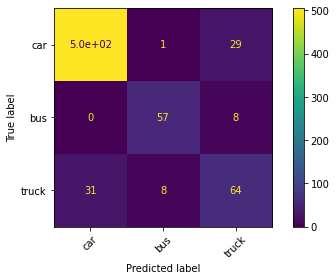

In [ ]:
results_interclass.plot_confusion_matrix()

Note that there appears to be confusion between car and truck classes.

The detection evaluation also added the attributes eval_fp, eval_tp, and eval_fn to every predicted detection indicating if it is a false positive, true positive, or false negative. 
Let's create a view to find the worst samples by sorting by eval_fp to visualize the results. 


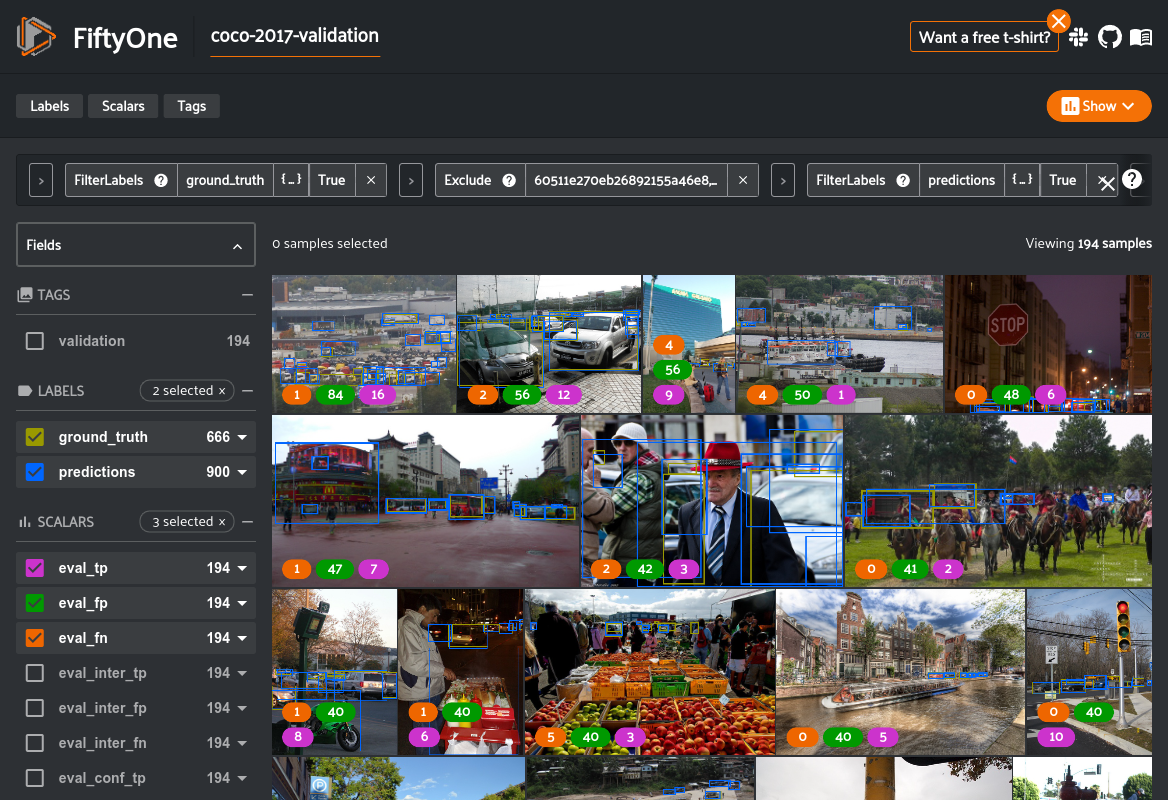

In [ ]:
session.view = test_view.sort_by("eval_fp", reverse=True)

Looking through some of these samples, we can see the confusion between the classes "car" and "truck" that we found earlier. However, this seems to be, at least in part, due to annotation errors on vans and SUVs where they are interchangably labeled as "car" and "truck". The example below shows an SUV annotated as "truck" but predicted as "car".


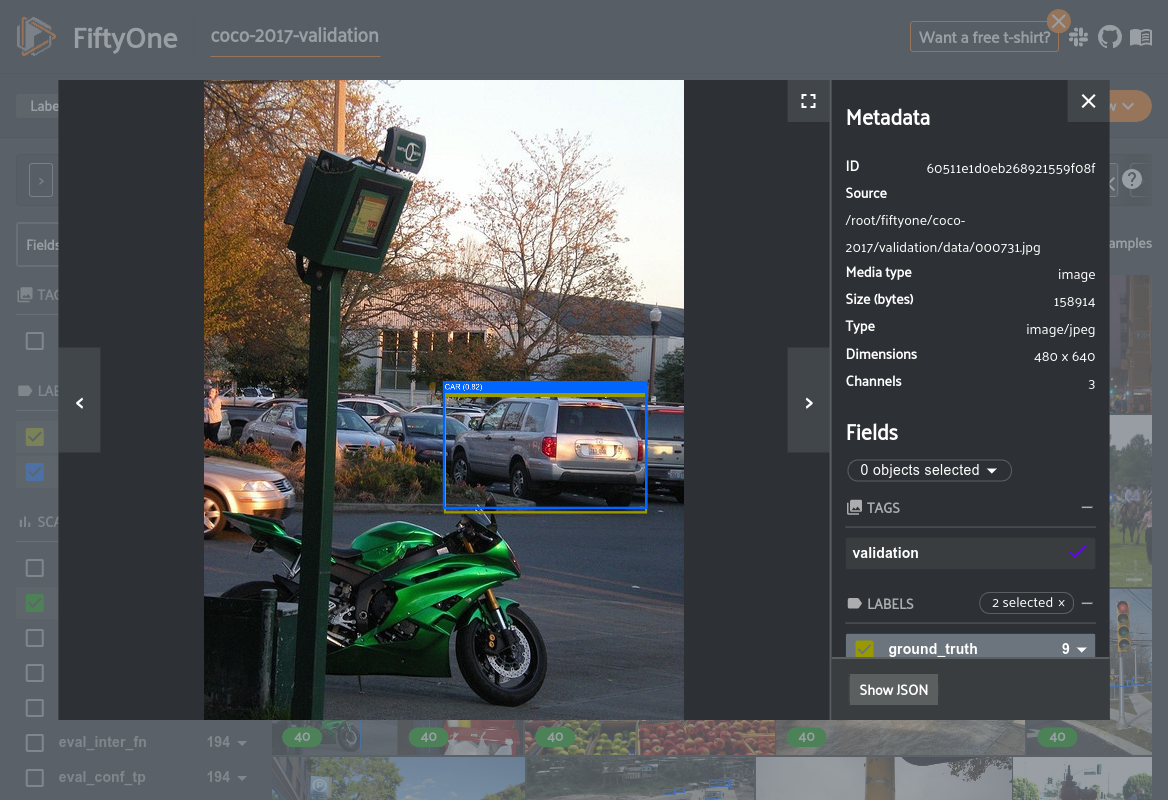

In [ ]:
session.view = test_view.sort_by("eval_fp", reverse=True)

In [ ]:
# map labels to single vehicle class 
vehicles_map = {c: "vehicle" for c in vehicles_list}

train_map_view = train_view.map_labels("ground_truth", vehicles_map)
test_map_view = test_view.map_labels("ground_truth", vehicles_map)

# use our dataset and defined transformations
torch_map_dataset = FiftyOneTorchDataset(train_map_view, train_transforms)
torch_map_dataset_test = FiftyOneTorchDataset(test_map_view, test_transforms)

In [ ]:
# Only 2 classes (background and vehicle)
vehicle_model = get_model(2)

In [ ]:
do_training(vehicle_model, torch_map_dataset, torch_map_dataset_test)

Using device cuda


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Epoch: [0]  [  0/250]  eta: 0:04:47  lr: 0.000025  loss: 1.5123 (1.5123)  loss_classifier: 0.9323 (0.9323)  loss_box_reg: 0.5551 (0.5551)  loss_objectness: 0.0071 (0.0071)  loss_rpn_box_reg: 0.0178 (0.0178)  time: 1.1514  data: 0.2843  max mem: 4401
Epoch: [0]  [ 10/250]  eta: 0:02:35  lr: 0.000226  loss: 1.1389 (1.1536)  loss_classifier: 0.8300 (0.7482)  loss_box_reg: 0.3211 (0.3252)  loss_objectness: 0.0288 (0.0414)  loss_rpn_box_reg: 0.0125 (0.0387)  time: 0.6473  data: 0.0319  max mem: 4401
Epoch: [0]  [ 20/250]  eta: 0:02:28  lr: 0.000426  loss: 1.0465 (1.0374)  loss_classifier: 0.5113 (0.5782)  loss_box_reg: 0.3211 (0.3764)  loss_objectness: 0.0261 (0.0420)  loss_rpn_box_reg: 0.0125 (0.0407)  time: 0.6196  data: 0.0066  max mem: 4401
Epoch: [0]  [ 30/250]  eta: 0:02:24  lr: 0.000627  loss: 0.7177 (0.9652)  loss_classifier: 0.3202 (0.5004)  loss_box_reg: 0.4171 (0.3951)  loss_objectness: 0.0187 (0.0346)  loss_rpn_box_reg: 0.0168 (0.0350)  time: 0.6625  data: 0.0066  max mem: 4401


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Test:  [  0/207]  eta: 0:01:10  model_time: 0.1596 (0.1596)  evaluator_time: 0.0073 (0.0073)  time: 0.3383  data: 0.1694  max mem: 4722
Test:  [100/207]  eta: 0:00:13  model_time: 0.1203 (0.1171)  evaluator_time: 0.0024 (0.0046)  time: 0.1296  data: 0.0037  max mem: 4722
Test:  [200/207]  eta: 0:00:00  model_time: 0.1130 (0.1172)  evaluator_time: 0.0025 (0.0047)  time: 0.1215  data: 0.0033  max mem: 4722
Test:  [206/207]  eta: 0:00:00  model_time: 0.1128 (0.1171)  evaluator_time: 0.0034 (0.0049)  time: 0.1248  data: 0.0033  max mem: 4722
Test: Total time: 0:00:26 (0.1281 s / it)
Averaged stats: model_time: 0.1128 (0.1171)  evaluator_time: 0.0034 (0.0049)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.262
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.507
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.245
 Average Precision  (AP) @[ I

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Epoch: [1]  [  0/250]  eta: 0:03:48  lr: 0.005000  loss: 0.2260 (0.2260)  loss_classifier: 0.0742 (0.0742)  loss_box_reg: 0.1216 (0.1216)  loss_objectness: 0.0229 (0.0229)  loss_rpn_box_reg: 0.0073 (0.0073)  time: 0.9124  data: 0.3390  max mem: 4722
Epoch: [1]  [ 10/250]  eta: 0:02:36  lr: 0.005000  loss: 0.4380 (0.4907)  loss_classifier: 0.1351 (0.1584)  loss_box_reg: 0.1715 (0.2241)  loss_objectness: 0.0317 (0.0482)  loss_rpn_box_reg: 0.0167 (0.0600)  time: 0.6532  data: 0.0360  max mem: 4722
Epoch: [1]  [ 20/250]  eta: 0:02:29  lr: 0.005000  loss: 0.3960 (0.4844)  loss_classifier: 0.1281 (0.1492)  loss_box_reg: 0.1715 (0.2056)  loss_objectness: 0.0358 (0.0673)  loss_rpn_box_reg: 0.0177 (0.0623)  time: 0.6360  data: 0.0061  max mem: 4722
Epoch: [1]  [ 30/250]  eta: 0:02:17  lr: 0.005000  loss: 0.3671 (0.4388)  loss_classifier: 0.1112 (0.1335)  loss_box_reg: 0.1653 (0.1906)  loss_objectness: 0.0371 (0.0578)  loss_rpn_box_reg: 0.0173 (0.0570)  time: 0.6098  data: 0.0066  max mem: 4722


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Test:  [  0/207]  eta: 0:01:11  model_time: 0.1580 (0.1580)  evaluator_time: 0.0092 (0.0092)  time: 0.3455  data: 0.1763  max mem: 4722
Test:  [100/207]  eta: 0:00:13  model_time: 0.1207 (0.1171)  evaluator_time: 0.0023 (0.0044)  time: 0.1285  data: 0.0037  max mem: 4722
Test:  [200/207]  eta: 0:00:00  model_time: 0.1136 (0.1171)  evaluator_time: 0.0022 (0.0044)  time: 0.1219  data: 0.0040  max mem: 4722
Test:  [206/207]  eta: 0:00:00  model_time: 0.1140 (0.1171)  evaluator_time: 0.0034 (0.0047)  time: 0.1263  data: 0.0040  max mem: 4722
Test: Total time: 0:00:26 (0.1280 s / it)
Averaged stats: model_time: 0.1140 (0.1171)  evaluator_time: 0.0034 (0.0047)
Accumulating evaluation results...
DONE (t=0.07s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.375
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.663
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.403
 Average Precision  (AP) @[ I

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Epoch: [2]  [  0/250]  eta: 0:03:53  lr: 0.005000  loss: 0.0637 (0.0637)  loss_classifier: 0.0306 (0.0306)  loss_box_reg: 0.0283 (0.0283)  loss_objectness: 0.0016 (0.0016)  loss_rpn_box_reg: 0.0031 (0.0031)  time: 0.9345  data: 0.3557  max mem: 4722
Epoch: [2]  [ 10/250]  eta: 0:02:39  lr: 0.005000  loss: 0.2129 (0.2930)  loss_classifier: 0.1072 (0.1128)  loss_box_reg: 0.1368 (0.1522)  loss_objectness: 0.0115 (0.0165)  loss_rpn_box_reg: 0.0088 (0.0114)  time: 0.6641  data: 0.0378  max mem: 4722
Epoch: [2]  [ 20/250]  eta: 0:02:31  lr: 0.005000  loss: 0.2121 (0.2590)  loss_classifier: 0.0808 (0.0958)  loss_box_reg: 0.0980 (0.1370)  loss_objectness: 0.0114 (0.0135)  loss_rpn_box_reg: 0.0087 (0.0126)  time: 0.6431  data: 0.0063  max mem: 4722
Epoch: [2]  [ 30/250]  eta: 0:02:24  lr: 0.005000  loss: 0.1546 (0.2640)  loss_classifier: 0.0635 (0.0953)  loss_box_reg: 0.0903 (0.1413)  loss_objectness: 0.0073 (0.0118)  loss_rpn_box_reg: 0.0068 (0.0156)  time: 0.6540  data: 0.0066  max mem: 4722


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Test:  [  0/207]  eta: 0:01:13  model_time: 0.1681 (0.1681)  evaluator_time: 0.0099 (0.0099)  time: 0.3561  data: 0.1761  max mem: 4722
Test:  [100/207]  eta: 0:00:13  model_time: 0.1202 (0.1168)  evaluator_time: 0.0027 (0.0050)  time: 0.1313  data: 0.0049  max mem: 4722
Test:  [200/207]  eta: 0:00:00  model_time: 0.1133 (0.1170)  evaluator_time: 0.0028 (0.0050)  time: 0.1222  data: 0.0033  max mem: 4722
Test:  [206/207]  eta: 0:00:00  model_time: 0.1137 (0.1170)  evaluator_time: 0.0036 (0.0052)  time: 0.1265  data: 0.0035  max mem: 4722
Test: Total time: 0:00:26 (0.1288 s / it)
Averaged stats: model_time: 0.1137 (0.1170)  evaluator_time: 0.0036 (0.0052)
Accumulating evaluation results...
DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.395
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.651
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.424
 Average Precision  (AP) @[ I

/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Epoch: [3]  [  0/250]  eta: 0:03:42  lr: 0.000500  loss: 0.2147 (0.2147)  loss_classifier: 0.0755 (0.0755)  loss_box_reg: 0.1179 (0.1179)  loss_objectness: 0.0143 (0.0143)  loss_rpn_box_reg: 0.0070 (0.0070)  time: 0.8897  data: 0.2764  max mem: 4722
Epoch: [3]  [ 10/250]  eta: 0:02:37  lr: 0.000500  loss: 0.2830 (0.3095)  loss_classifier: 0.1161 (0.1141)  loss_box_reg: 0.1569 (0.1598)  loss_objectness: 0.0143 (0.0162)  loss_rpn_box_reg: 0.0080 (0.0194)  time: 0.6581  data: 0.0305  max mem: 4722
Epoch: [3]  [ 20/250]  eta: 0:02:23  lr: 0.000500  loss: 0.2830 (0.3167)  loss_classifier: 0.1070 (0.1103)  loss_box_reg: 0.1588 (0.1722)  loss_objectness: 0.0136 (0.0172)  loss_rpn_box_reg: 0.0091 (0.0170)  time: 0.6128  data: 0.0061  max mem: 4722
Epoch: [3]  [ 30/250]  eta: 0:02:15  lr: 0.000500  loss: 0.2080 (0.2815)  loss_classifier: 0.0735 (0.0976)  loss_box_reg: 0.1270 (0.1549)  loss_objectness: 0.0091 (0.0153)  loss_rpn_box_reg: 0.0081 (0.0137)  time: 0.5902  data: 0.0065  max mem: 4722


/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "
/usr/local/lib/python3.7/dist-packages/pymongo/topology.py:162: UserWarning: MongoClient opened before fork. Create MongoClient only after forking. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  "MongoClient opened before fork. Create MongoClient only "


Test:  [  0/207]  eta: 0:01:11  model_time: 0.1685 (0.1685)  evaluator_time: 0.0073 (0.0073)  time: 0.3448  data: 0.1672  max mem: 4722
Test:  [100/207]  eta: 0:00:13  model_time: 0.1207 (0.1173)  evaluator_time: 0.0019 (0.0033)  time: 0.1277  data: 0.0034  max mem: 4722
Test:  [200/207]  eta: 0:00:00  model_time: 0.1126 (0.1174)  evaluator_time: 0.0018 (0.0033)  time: 0.1206  data: 0.0035  max mem: 4722
Test:  [206/207]  eta: 0:00:00  model_time: 0.1136 (0.1174)  evaluator_time: 0.0026 (0.0035)  time: 0.1245  data: 0.0035  max mem: 4722
Test: Total time: 0:00:26 (0.1267 s / it)
Averaged stats: model_time: 0.1136 (0.1174)  evaluator_time: 0.0026 (0.0035)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.428
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.688
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.459
 Average Precision  (AP) @[ I

In [ ]:
add_detections(vehicle_model, torch_map_dataset_test, test_map_view, field_name="vehicle_predictions")

Using device cuda
 100% |█████████████████| 207/207 [34.8s elapsed, 0s remaining, 5.5 samples/s]      


In [ ]:
vehicle_results = fo.evaluate_detections(
    test_map_view, 
    "vehicle_predictions", 
    classes=["vehicle"], 
    eval_key="vehicle_eval", 
    compute_mAP=True
)

Evaluating detections...
 100% |█████████████████| 207/207 [5.4s elapsed, 0s remaining, 36.1 samples/s]      
Performing IoU sweep...
 100% |█████████████████| 207/207 [10.0s elapsed, 0s remaining, 15.6 samples/s]      


In [ ]:
vehicle_results.mAP()

0.43066431144550577

In [ ]:
vehicle_results.print_report()

              precision    recall  f1-score   support

     vehicle       0.18      0.89      0.30       791

   micro avg       0.18      0.89      0.30       791
   macro avg       0.18      0.89      0.30       791
weighted avg       0.18      0.89      0.30       791

